## Sentiment Analysis on IMDB movie reviews using Pyspark.

#### Problem statement: Analysing movie reviews and understanding what kind of movies viewers like by deriving positive and negative sentiments from the text.

#### We have used traditional sentiment analysis approach as well as a data science approach which involves Estimators, Transformers and applying a Machine learning algorithm for our sentiment analysis, where 1 states Positive and 0 states Negative.

#### Data Description: We are using a sample dataset from IMDB which has 3 columns (reviews of movie, post id, review score).  The dataset has been taken from kaggle.com. https://www.kaggle.com/utathya/imdb-review-dataset

In [1]:
#importing the numpy, pandas and matplotlib libraries for our data cleaning and exploratory data analysis.
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
#uploading the files in the cloudera environment using CLI commands.

!hdfs dfs -put IMDB.csv /user/cloudera
!hdfs dfs -put imdb_clean.csv /user/cloudera
!hdfs dfs -put sentiments.csv /user/cloudera
!hdfs dfs -put stop_words.txt /user/cloudera

In [7]:
df = pd.read_csv("IMDB.csv")
df.head()

,id,review,score
0,pos_10006,"In this ""critically acclaimed psychological th...",1
1,pos_10013,"Like one of the previous commenters said, this...",1
2,pos_10022,Aro Tolbukhin burnt alive seven people in a Mi...,1
3,pos_10033,The movie Titanic makes it much more then just...,1
4,pos_1003,"Another Aussie masterpiece, this delves into t...",1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
id        25000 non-null object
review    25000 non-null object
score     25000 non-null int64
dtypes: int64(1), object(2)
memory usage: 586.0+ KB


In [7]:
# we have an equal data distribution for positive and negative scores.
df.score.value_counts()

1    12500
0    12500
Name: score, dtype: int64

### 1. Data Cleaning

In [10]:
df.review[10]

'Fabulous costumes by Edith Head who painted them on Liz Taylor at her finest!<br /><br />The SFX are very good for a movie of its age, and the stunt doubles actually looked like the actors, even down to body type, a rarity in movies of this vintage.<br /><br />A cozy movie, with splendid panoramas -- even when chopped down to pan and scan.'

In [11]:
#importing the beautiful soal and regular expression libraries for data cleaning.
from bs4 import BeautifulSoup
import re

#testing the results for review number 10 and we see that the HTML tags (<br/>) are removed.
test = BeautifulSoup(df.review[10], 'lxml')
print(test.get_text())

Fabulous costumes by Edith Head who painted them on Liz Taylor at her finest!The SFX are very good for a movie of its age, and the stunt doubles actually looked like the actors, even down to body type, a rarity in movies of this vintage.A cozy movie, with splendid panoramas -- even when chopped down to pan and scan.


In [12]:
#importing an ntlk library function 'WordPunctTokenizer' which divides a string into substrings by splitting.
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()

In [13]:
reg1 = r'@[A-Za-z0-9]+' #removing numbers and special characters
reg2 = r'<[^<]+?>'  #removing special characters. 
comb = r'|'.join((reg1, reg2)) #joining both the reg regression variables and will use it below in our function.

In [14]:
#created a function 'clean' for cleaning the review text using beautiful soap and reg exp as defined above.
def clean(review):
    s = BeautifulSoup(review, 'lxml')
    s_soup = s.get_text()
    strip = re.sub(comb, '', s_soup)
    letter = re.sub("[^a-zA-Z]", " ", strip)
    lower = letter.lower()
    word = tok.tokenize(lower)
    return (" ".join(word)).strip()

In [15]:
#testing the clean function for 10 rows.
test = df.review[:10]

In [16]:
result = []  #empty string appended with each iteration of review cleaning.
for t in test:
    result.append(clean(t)) #calling the clean function

In [17]:
result #display the cleaned text

['in this critically acclaimed psychological thriller based on true events gabriel robin williams a celebrated writer and late night talk show host becomes captivated by the harrowing story of a young listener and his adoptive mother toni collette when troubling questions arise about this boy s story however gabriel finds himself drawn into a widening mystery that hides a deadly secret according to film s official synopsis you really should stop reading these comments and watch the film now the how did he lose his leg ending with ms collette planning her new life should be chopped off and sent to deleted scenes land it s overkill the true nature of her physical and mental ailments should be obvious by the time mr williams returns to new york possibly her blindness could be in question but a revelation could have be made certain in either the highway or video tape scenes the film would benefit from a re editing how about a director s cut williams and bobby cannavale as jess don t seem i

#### Now we clean the entire data in the review column. We have splitted the rows in 2 parts and will clean in steps to reduce the runtime.

In [18]:
n = [0,10000,25000] 
#running a loop for cleaning the data field in parts and appendng the cleaned data in a list 'clean_reviews'

In [19]:
%%time 
print ("Cleaning the reviews part 1")
clean_reviews = []
for i in range(n[0],n[1]):                                                                
    clean_reviews.append(clean(df['review'][i]))

Cleaning the reviews part 1
CPU times: user 6.08 s, sys: 81 ms, total: 6.16 s
Wall time: 8.15 s


In [20]:
%%time
print ("Cleaning the reviews part 2")
for i in range(n[1],n[2]):                                                                 
    clean_reviews.append(clean(df['review'][i]))

Cleaning the reviews part 2
CPU times: user 8.74 s, sys: 1.39 s, total: 10.1 s
Wall time: 14 s


In [21]:
len(clean_reviews) #length of the review rows cleaned

25000

#### saving the cleaned data in a new csv file 'imdb_clean_csv'

In [22]:
new_df = pd.DataFrame(clean_reviews,columns=['review'])
new_df['id'] = df.id
new_df['sentiment'] = df.score
new_df.head()

,review,id,sentiment
0,in this critically acclaimed psychological thr...,pos_10006,1
1,like one of the previous commenters said this ...,pos_10013,1
2,aro tolbukhin burnt alive seven people in a mi...,pos_10022,1
3,the movie titanic makes it much more then just...,pos_10033,1
4,another aussie masterpiece this delves into th...,pos_1003,1


In [23]:
new_df.to_csv('imdb_clean.csv',encoding='utf-8')
csv = 'imdb_clean.csv'

### 2. Exploratory Data Analysis

1. For visualization we have used a Wordcloud to view the frequency of the words as per the review column. 
2. A bar plot is created to plot the total no of positive and negative words for overall sentiment comparison.

In [24]:
import collections
from wordcloud import WordCloud #importing the wordcloud library
import matplotlib.pyplot as plt

In [25]:
#We are converting the datafrome to str datatype so that we could give it as input in word cloud.
arr = new_df.review.values
obj = np.array2string(arr, precision=2, separator=',',suppress_small=True)
type(obj)

str

#### Insight 1: Word Cloud is used to see the most used words in IMDB Reviews. We could see that film, scene and movie are some of the most used words. We can infer that words like revenge, rape, brutality are used more frequently and this might be a strong reason for the sentiment of the movie. Genere has a major influence on the sentiments. 

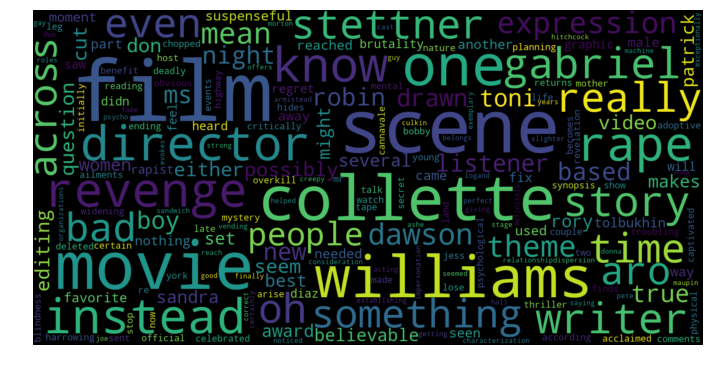

In [26]:
wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(obj)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [28]:
dfsplit = pd.DataFrame(obj.split())
dfsplit.head()

,0
0,['in
1,this
2,critically
3,acclaimed
4,psychological


In [29]:
dftokenized = pd.DataFrame(WordPunctTokenizer().tokenize(obj), columns=['word'])
dftokenized.head()

,word
0,['
1,in
2,this
3,critically
4,acclaimed


We could see the difference between tokenizer and split function from above 2 cases. A Tokenizer seperates the special characters from data as well and hence we are using tokenizer.

In [30]:
# We have used a bucket of word dictionary which has predefined sentiments assigned to words.
dfWordList = pd.read_csv("sentiments.csv")
dfWordList.head()

,word,sentiment
0,gratefully,1
1,gratification,1
2,gratified,1
3,gratifies,1
4,gratify,1


In [31]:
#Merging the sentiments data with wordList dictionary to get sentiment of each word in review.
merged_df = pd.merge(dfWordList, dftokenized, on='word', how='inner')
grouped_df = merged_df.groupby('sentiment', as_index = False).count()

#### Insight 2: From the Bar graph below we can inferthat the overall sentiment through movie reviews are negative.

[Text(0,0,'Negative'), Text(0,0,'Positive')]

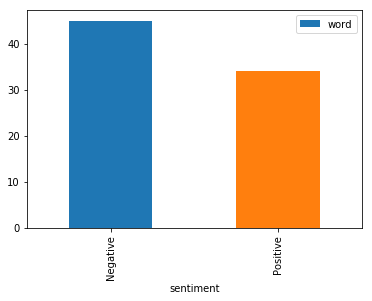

In [32]:
labels_word = ['Negative','Positive']
ax = grouped_df.plot(kind = 'bar', x = 'sentiment', y = 'word')
ax.set_xticklabels(labels_word)

### 3. Simple method for performing Sentiment Analysis.

We are using a simple approach for performing our analysis and we will be using the clean data set 'imdb_clean' we created in the pervious section.

In [33]:
#importing the spark api libraries for future analysis on sql spark context.

#we are running on the local cluster with 4 nodes, but its scalable for multicluster enivironment as well.

from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import functions as fn 
import findspark
findspark.init()
import warnings

conf = SparkConf().setMaster("local[4]").setAppName("Big_Data_Project")  
sc = SparkContext.getOrCreate(conf = conf)
sqlContext = SQLContext(sc)

In [34]:
#creating an sql context for reading the cleaned data in spark sql data frame.
imdb_clean_df = sqlContext.read.format('com.databricks.spark.csv').options(header = 'true', inferschema='true').load('imdb_clean.csv')

In [35]:
type(imdb_clean_df)

pyspark.sql.dataframe.DataFrame

In [36]:
imdb_clean_df.show(5) #here we can see the data is in cleaned format and loaded succesfully.

+---+--------------------+---------+---------+
|_c0|              review|       id|sentiment|
+---+--------------------+---------+---------+
|  0|in this criticall...|pos_10006|        1|
|  1|like one of the p...|pos_10013|        1|
|  2|aro tolbukhin bur...|pos_10022|        1|
|  3|the movie titanic...|pos_10033|        1|
|  4|another aussie ma...| pos_1003|        1|
+---+--------------------+---------+---------+
only showing top 5 rows



In [37]:
imdb_clean_df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- review: string (nullable = true)
 |-- id: string (nullable = true)
 |-- sentiment: integer (nullable = true)



In [38]:
#viewing the first postive reviews from the cleaned dataframe.
imdb_clean_df.where(fn.col('sentiment') == 1).first()

Row(_c0=0, review='in this critically acclaimed psychological thriller based on true events gabriel robin williams a celebrated writer and late night talk show host becomes captivated by the harrowing story of a young listener and his adoptive mother toni collette when troubling questions arise about this boy s story however gabriel finds himself drawn into a widening mystery that hides a deadly secret according to film s official synopsis you really should stop reading these comments and watch the film now the how did he lose his leg ending with ms collette planning her new life should be chopped off and sent to deleted scenes land it s overkill the true nature of her physical and mental ailments should be obvious by the time mr williams returns to new york possibly her blindness could be in question but a revelation could have be made certain in either the highway or video tape scenes the film would benefit from a re editing how about a director s cut williams and bobby cannavale as 

In [39]:
#viewing the first negative sentiment reviews.
imdb_clean_df.where(fn.col('sentiment') == 0).first()

Row(_c0=1238, review='i don t know who to blame the timid writers or the clueless director it seemed to be one of those movies where so much was paid to the stars angie charlie denise rosanna and jon that there wasn t enough left to really make a movie this could have been very entertaining but there was a veil of timidity even cowardice that hung over each scene since it got an r rating anyway why was the ubiquitous bubble bath scene shot with a year old woman and not angie harmon why does sheen sleepwalk through potentially hot relationships with two of the most beautiful and sexy actresses in the world if they were only looking for laughs why not cast whoopi goldberg and judy tenuta instead this was so predictable i was surprised to find that the director wasn t a five year old what a waste not just for the viewers but for the actors as well', id='neg_10006', sentiment=0)

In [40]:
#computing the average review length for positive and negative reviews. 

In [41]:
pr = imdb_clean_df.select(fn.length('review').alias('Positive Review Length')).where(fn.col('sentiment') == 1)
pr.select(fn.avg('Positive Review Length')).show()

+---------------------------+
|avg(Positive Review Length)|
+---------------------------+
|                  1285.1108|
+---------------------------+



In [42]:
nr = imdb_clean_df.select(fn.length('review').alias('Negative Review Length')).where(fn.col('sentiment') == 0)
nr.select(fn.avg('Negative Review Length')).show()

+---------------------------+
|avg(Negative Review Length)|
+---------------------------+
|                  1238.8004|
+---------------------------+



#### Insight 3: we analysed that the average length size for the positive reviews text are more than negative reviews.

The review column is split into words using Tokenizer and we have joined it with an existing bucket of words with predefined sentiments to compute an average sentiment for each post id.

In [44]:
#reading the file in a dataframe.
bucket_df = sqlContext.read.format('com.databricks.spark.csv').options(header = 'true', inferschema='true').load('sentiments.csv')

In [45]:
bucket_df.printSchema()

root
 |-- word: string (nullable = true)
 |-- sentiment: integer (nullable = true)



In [46]:
bucket_df.show(5) #display postive words

+-------------+---------+
|         word|sentiment|
+-------------+---------+
|   gratefully|        1|
|gratification|        1|
|    gratified|        1|
|    gratifies|        1|
|      gratify|        1|
+-------------+---------+
only showing top 5 rows



In [47]:
bucket_df.where(fn.col('sentiment') == -1).show(5) #display negative words

+----------+---------+
|      word|sentiment|
+----------+---------+
|   2-faced|       -1|
|   2-faces|       -1|
|  abnormal|       -1|
|   abolish|       -1|
|abominable|       -1|
+----------+---------+
only showing top 5 rows



In [48]:
from pyspark.ml.feature import RegexTokenizer

In [49]:
#creating a tokenizer object for spliting the input review column and creating a new output column 'split' 
token = RegexTokenizer().setGaps(False).setPattern("\\p{L}+").setInputCol("review").setOutputCol("split")

In [50]:
#used the token transformer for applying the changes.
df_word = token.transform(imdb_clean_df)
df_word.show(5)

+---+--------------------+---------+---------+--------------------+
|_c0|              review|       id|sentiment|               split|
+---+--------------------+---------+---------+--------------------+
|  0|in this criticall...|pos_10006|        1|[in, this, critic...|
|  1|like one of the p...|pos_10013|        1|[like, one, of, t...|
|  2|aro tolbukhin bur...|pos_10022|        1|[aro, tolbukhin, ...|
|  3|the movie titanic...|pos_10033|        1|[the, movie, tita...|
|  4|another aussie ma...| pos_1003|        1|[another, aussie,...|
+---+--------------------+---------+---------+--------------------+
only showing top 5 rows



In [51]:
#We will compare with the bucket words by exploding the split words into different rows using f.explode function 
#and join the dataframes on word.
joined_df = df_word.select('id', fn.explode('split').alias('word')).join(bucket_df, 'word')
joined_df.show(5)

+----------+---------+---------+
|      word|       id|sentiment|
+----------+---------+---------+
| acclaimed|pos_10006|        1|
|celebrated|pos_10006|        1|
| troubling|pos_10006|       -1|
|   mystery|pos_10006|       -1|
|    deadly|pos_10006|       -1|
+----------+---------+---------+
only showing top 5 rows



we would take the average sentiment of the words for each review and classify the post as "Positive" when avg sent is greater than 0 and negative if less and then compute the accuracy score of this method.

In [52]:
predict_df = joined_df.groupBy('id').agg(fn.avg('sentiment').alias('avg_sent')).withColumn('pred_sent', fn.when(fn.col('avg_sent') > 0, 1).otherwise(0))
predict_df.show(5)

+---------+--------------------+---------+
|       id|            avg_sent|pred_sent|
+---------+--------------------+---------+
|pos_10149| 0.42857142857142855|        1|
|pos_10377|  0.5384615384615384|        1|
| pos_1299| 0.09090909090909091|        1|
| pos_2228|-0.14285714285714285|        0|
| pos_5052|  0.7777777777777778|        1|
+---------+--------------------+---------+
only showing top 5 rows



Accuracy Score:

In [53]:
imdb_clean_df.join(predict_df, 'id').select(fn.expr('float(sentiment = pred_sent)').alias('accuracy')).select(fn.avg('accuracy')).show(5)

+------------------+
|     avg(accuracy)|
+------------------+
|0.7321114134784696|
+------------------+



### 4. Machine Learning approach for Sentiment analysis

In [54]:
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF, Tokenizer

#### a. stop words removal.

In [56]:
#reading a text file with stop words and we will be fitering these words from our review column.

with open("stop_words.txt") as f:
    stop = f.read().split()

In [57]:
stop[1:10] #display 10 words from the list.

['about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost']

In [58]:
#removing the stop words.
from pyspark.ml.feature import StopWordsRemover
filter = StopWordsRemover().setStopWords(stop).setCaseSensitive(False).setInputCol("split").setOutputCol("filter_words")

#### b. Count Vectorizer 

In [59]:
# we will remove the words that appear in 8 docs or less.
from pyspark.ml.feature import CountVectorizer
count_vector = CountVectorizer(minTF=1, minDF=8, vocabSize=2**17).setInputCol("filter_words").setOutputCol("TF")

#### c. Pipeline Estimator and Transformer

In [60]:
# we now create a pipelined estimator.
CVP = Pipeline(stages=[token, filter, count_vector]).fit(imdb_clean_df)

In [61]:
#applying the transformation to the dataframe.
CVP.transform(imdb_clean_df).show(5)

+---+--------------------+---------+---------+--------------------+--------------------+--------------------+
|_c0|              review|       id|sentiment|               split|        filter_words|                  TF|
+---+--------------------+---------+---------+--------------------+--------------------+--------------------+
|  0|in this criticall...|pos_10006|        1|[in, this, critic...|[critically, accl...|(20491,[0,2,3,4,6...|
|  1|like one of the p...|pos_10013|        1|[like, one, of, t...|[like, previous, ...|(20491,[0,1,2,3,4...|
|  2|aro tolbukhin bur...|pos_10022|        1|[aro, tolbukhin, ...|[aro, tolbukhin, ...|(20491,[0,1,11,30...|
|  3|the movie titanic...|pos_10033|        1|[the, movie, tita...|[movie, titanic, ...|(20491,[0,1,2,3,4...|
|  4|another aussie ma...| pos_1003|        1|[another, aussie,...|[aussie, masterpi...|(20491,[3,4,8,23,...|
+---+--------------------+---------+---------+--------------------+--------------------+--------------------+
only showi

#### d. IDF (Inverse Document Frequency)

In [62]:
from pyspark.ml.feature import IDF
IDF = IDF().setInputCol('TF').setOutputCol('TF_IDF')

In [63]:
#creating an IDF pipeline
IDF_pip = Pipeline(stages=[CVP, IDF]).fit(imdb_clean_df)

In [64]:
#applying the transformation.
TF_IDF = IDF_pip.transform(imdb_clean_df)
TF_IDF.select('id', 'filter_words', 'TF', "TF_IDF").show(4)

+---------+--------------------+--------------------+--------------------+
|       id|        filter_words|                  TF|              TF_IDF|
+---------+--------------------+--------------------+--------------------+
|pos_10006|[critically, accl...|(20491,[0,2,3,4,6...|(20491,[0,2,3,4,6...|
|pos_10013|[like, previous, ...|(20491,[0,1,2,3,4...|(20491,[0,1,2,3,4...|
|pos_10022|[aro, tolbukhin, ...|(20491,[0,1,11,30...|(20491,[0,1,11,30...|
|pos_10033|[movie, titanic, ...|(20491,[0,1,2,3,4...|(20491,[0,1,2,3,4...|
+---------+--------------------+--------------------+--------------------+
only showing top 4 rows



#### e. splitting the data into training, validation, and testing dataframes in 90:5:5 ratio

In [65]:
train_df, val_df, test_df = imdb_clean_df.randomSplit([0.90, 0.5, 0.5], seed=0)

In [66]:
train_df.count(), val_df.count(), test_df.count()

(11957, 6529, 6514)

### 5. Logistic Regression Model 

In [67]:
#using the TF_IDF features from IDF pipeline and feeding it to the Logistic regression model.

from pyspark.ml.classification import LogisticRegression
LR = LogisticRegression().setLabelCol('sentiment').setFeaturesCol('TF_IDF').setMaxIter(100)

In [68]:
#creating a pipeline transformation for logistic regression and running on the training data set.
LR_pip = Pipeline(stages=[IDF_pip, LR]).fit(train_df)

In [69]:
#applying the transformation on the validation data frame for predicting the sentiments.
LR_pip.transform(val_df).select('id', 'sentiment', 'prediction').show(5)

+---------+---------+----------+
|       id|sentiment|prediction|
+---------+---------+----------+
|pos_10022|        1|       0.0|
|pos_10053|        1|       1.0|
|pos_10096|        1|       1.0|
|pos_10101|        1|       1.0|
|pos_10129|        1|       1.0|
+---------+---------+----------+
only showing top 5 rows



In [70]:
#applying the transformation on the test data frame
pred_test = LR_pip.transform(test_df).select('id', 'sentiment', 'prediction')
pred_test.show(5)

+---------+---------+----------+
|       id|sentiment|prediction|
+---------+---------+----------+
|pos_10006|        1|       0.0|
|pos_10033|        1|       1.0|
| pos_1003|        1|       1.0|
| pos_1004|        1|       1.0|
|pos_10062|        1|       1.0|
+---------+---------+----------+
only showing top 5 rows



#### Calculating the Accuracy score on the testing data set for our ML model.

In [71]:
accuracy = pred_test.filter(pred_test.sentiment == pred_test.prediction).count() / float(test_df.count())
accuracy

0.8380411421553577

#### Insight 6: The accuracy has increased by 10% when a machine learning algorithm is used for SA compared to the bucket approach where the accuracy was 0.73

### Overall Insights:

1. The accuracy of prediction increases when machine learning model combined with spark estimators and transformers is applied on the sentiment dataset.

2. Words which frequently appear in the data can create a bias while predicting the sentiments and this can be resolved by using count vectorization and IDF methods, which neutralizes the weight effect of those words.

3. We earlier observed from our EDA that overall sentiment of the reviews was negative, and this might be due to the brutality involved in the movies as shown in the word cloud. Therefore, we believe the filmmakers should classify the movies appropriately with proper certifications as to avoid any unwanted negative reviews.

### Problems associated with SA:

1. Detecting sentiments for sarcasm.

2. Multiple opinions in a single statement using words like “But, however” which can change the entire sentiment of a sentence.

### Recommendations & future roadmaps:

1. Techniques like Regularization can be applied along with Machine learning for optimization. 

2. Spark streaming API can be used to extract live data feeds from platforms for performing sentiment analysis.